In [31]:
import os
import pandas as pd
import collections
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import re
import numpy as np
import spacy
import textdescriptives as td
from tqdm import tqdm
import seaborn as sns

In [ ]:
def load_data(path_to_folder):
    all_files = os.listdir(path_to_folder) 
    valid_files = [file for file in all_files if 'errors' not in file] # remove error logs
    dfs = []
    for file in valid_files:
        file_path = os.path.join(path_to_folder, file)
        filename = str(file.split('.')[0])
        fandom = str(filename.split('_')[0])
        au = str(filename.split('_')[1])
        try:
            print(f"Loading file: {file}")
            df = pd.read_csv(file_path)
            df['Main fandom'] = fandom
            df['Main AU'] = au
            dfs.append(df) # load files into list of dfs
            print(f"Finished loading file: {file}")
        except Exception as e:
            print(f"Could not read {file}: {e}") # in case sth is missed
    big_df = pd.concat(dfs, ignore_index=True) # pull into df
    return big_df

path = os.path.join('..', '..', 'texts')
df = load_data(path)

Loading file: hp_coffeeshop.csv
Finished loading file: hp_coffeeshop.csv
Loading file: hp_vampire.csv
Finished loading file: hp_vampire.csv
Loading file: mcu_vampire.csv
Finished loading file: mcu_vampire.csv
Loading file: bts_vampire.csv
Finished loading file: bts_vampire.csv
Loading file: bnha_royalty.csv
Finished loading file: bnha_royalty.csv
Loading file: mcu_royalty.csv
Finished loading file: mcu_royalty.csv
Loading file: mcu_coffeeshop.csv
Finished loading file: mcu_coffeeshop.csv
Loading file: bnha_coffeeshop.csv
Finished loading file: bnha_coffeeshop.csv
Loading file: bts_coffeeshop.csv
Finished loading file: bts_coffeeshop.csv
Loading file: bnha_vampire.csv
Finished loading file: bnha_vampire.csv
Loading file: mcu_soulmates.csv
Finished loading file: mcu_soulmates.csv
Loading file: bts_soulmates.csv
Finished loading file: bts_soulmates.csv
Loading file: hp_royalty.csv
Finished loading file: hp_royalty.csv
Loading file: hp_soulmates.csv
Finished loading file: hp_soulmates.csv


In [3]:
def str_to_list(value):
    if pd.isna(value): 
        value = []
        return value
    elif isinstance(value, str):
        value = value.strip("[]").replace("'", "").split(", ")
        return value
    else:
        pass
    
def str_cols_to_list(data, cols):
    for col in cols:
        data[col] = data[col].apply(str_to_list)
    return data

def str_to_int(value):
    if pd.isna(value): 
        value = 0
        value = int(value)
        return value
    elif isinstance(value, int):
        pass
    elif isinstance(value, float):
        value = int(value)
        return(value)
    elif isinstance(value, str):
        value = value.replace(",", "").replace(".0", "")
        value = int(value)
        return value
    else:
        print(f"Look at this weird value: {value}")

def str_cols_to_int(data, cols):
    for col in cols:
        data[col] = data[col].apply(str_to_int)
    return data

def str_to_date(data, cols):
    for col in cols:
        data[col] = pd.to_datetime(data[col], errors='coerce')
    return data

df[['current_chapters', 'total_chapters']] = df['chapters'].str.split('/', expand=True)
df = df.drop(columns=['chapters'])

str_columns = ['author', 'category', 'fandom', 'relationship', 'character', 'additional tags', 'all_kudos']
df = str_cols_to_list(df, str_columns)

int_columns = ['words', 'comments', 'kudos', 'bookmarks', 'hits']
df = str_cols_to_int(df, int_columns)

date_cols = ['published', 'status date']
df = str_to_date(df, date_cols)

In [5]:
len_orig = df.shape[0]

In [ ]:
cross_df = pd.read_csv(), header=None)
cross_values = cross_df.iloc[:, 0].values
df = df[~df['work_id'].isin(cross_values)]

In [8]:
len_no_xover = df.shape[0]

In [12]:
df = df.drop_duplicates(subset='work_id')

In [13]:
len_no_dupes = df.shape[0]

In [9]:
df = df[df['words'] >= 600]

In [11]:
len_length = df.shape[0]

In [12]:
snippets = []

for text in tqdm(list(df["body"]), total=df.shape[0]):
    text = str(text)
    clean_text = text.replace("\n", " ")
    tokenized_text = clean_text.split(" ")
    tokenized_text = [token for token in tokenized_text if token != ""]

    snippets.append(" ".join(tokenized_text[100:600]))


100%|██████████| 26938/26938 [00:26<00:00, 1015.21it/s]


In [13]:
spacy.load("en_core_web_lg")

In [ ]:
metrics = td.extract_metrics(
    text=tqdm(snippets), 
    spacy_model='en_core_web_lg', 
    metrics=['quality'])
df['passed_qual_check'] = list(metrics['passed_quality_check'])

100%|██████████| 26938/26938 [51:28<00:00,  8.72it/s]  


In [14]:
df['passed_qual_check'] = np.random.choice([True, False], size=len(df))

In [17]:
df = df[df['passed_qual_check'] == True]

In [18]:
len_final = df.shape[0]

In [19]:
prep_stats_path = os.path.join("..", "out", "prep_stats.txt")
with open(prep_stats_path, "w") as file:
    file.write(f"Original number of fics: {len_orig}\n")
    file.write(f"After removing crossovers: {len_no_xover}\n")
    file.write(f"After removing removing duplicates: {len_no_dupes}\n")
    file.write(f"After removing fics of insufficient length: {len_length}\n")
    file.write(f"After removing fics of insufficient quality: {len_final}\n")

In [21]:
au_fandom_counts = pd.crosstab(df['Main AU'], df['Main fandom'])

In [23]:
au_fandom_path = os.path.join("..", "out", "au_fandom_counts.csv")
au_fandom_counts.to_csv(au_fandom_path)

In [ ]:
pickle_path = os.path.join("..", "obj", "prepped_data.pkl")
df.to_pickle(pickle_path)

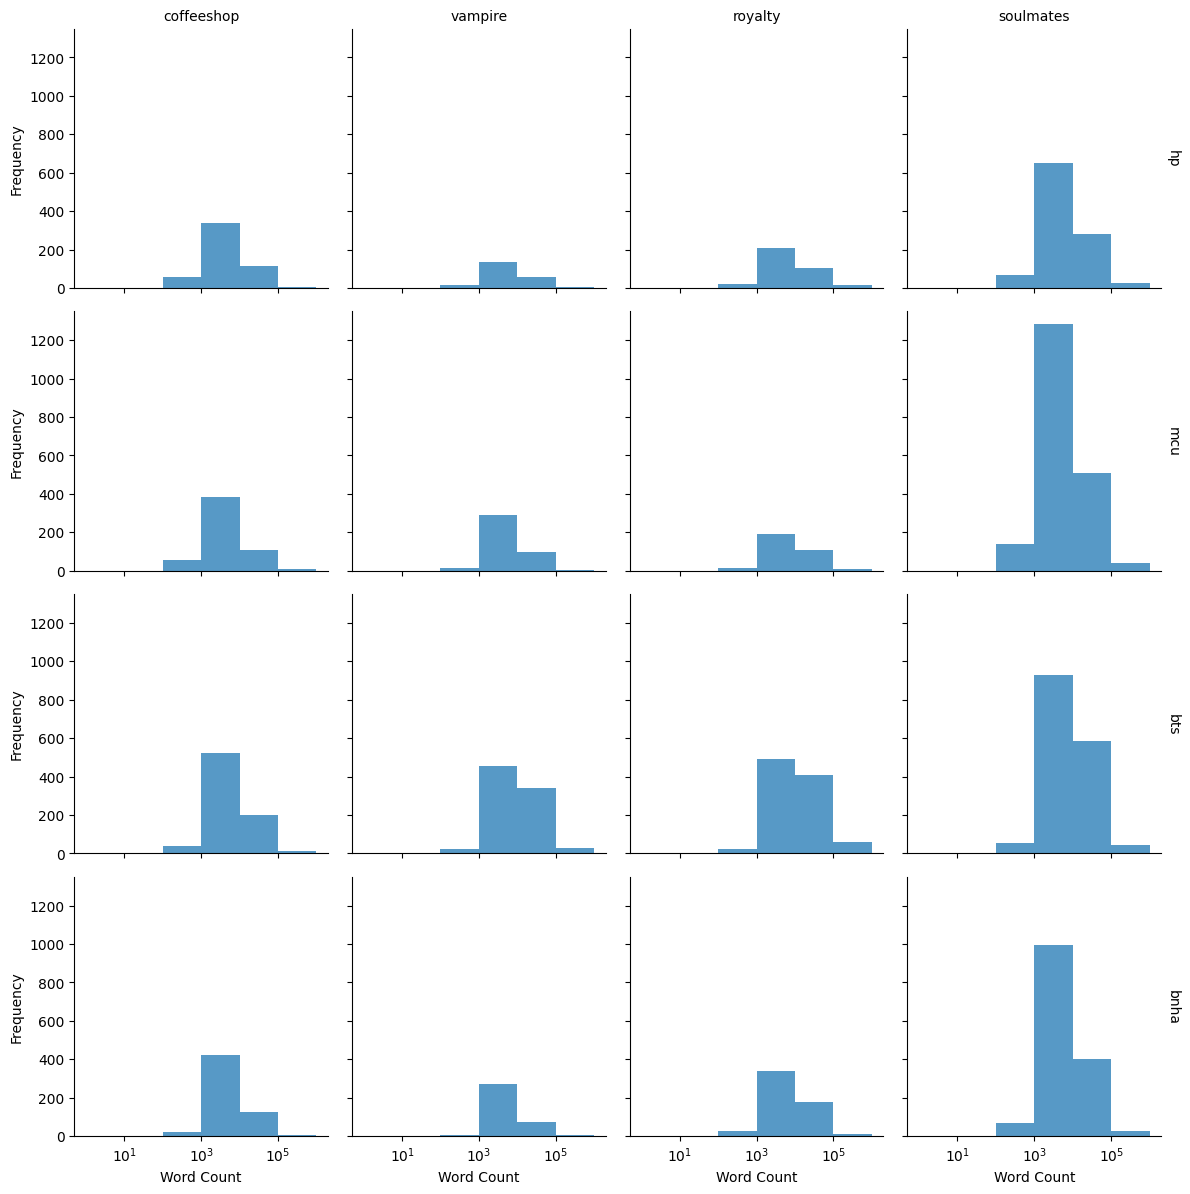

In [33]:
# Define fixed bin edges (0, 1, 10, 100, 1000, 10000, ...)
bins = [0, 1, 10, 100, 1_000, 10_000, 100_000, 1_000_000]  
bin_labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]
df["word_bins"] = pd.cut(df["words"], bins=bins, labels=bin_labels, include_lowest=True)

# Plot
g = sns.FacetGrid(df, col="Main AU", row="Main fandom", margin_titles=True, sharex=True, sharey=True)
g.map_dataframe(sns.histplot, x="words", bins=bins)

# Adjust aesthetics
g.set_axis_labels("Word Count", "Frequency")
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.set(xscale="log")  # Log-scale x-axis for proper binning
plt.show()